# Importing Relevant Libraries

In [ ]:
!pip install jovian --upgrade --quiet

In [26]:
import jovian
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
from torchvision.utils import make_grid
%matplotlib inline

In [27]:
project_name = 'final-course-project'

In [54]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/moaaz645/final-course-project


<IPython.core.display.Javascript object>

# Importing and Arranging the Data

In [29]:
test_df = pd.read_csv('../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv', sep=",")
train_df = pd.read_csv('../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv', sep=",")

In [30]:
labels = train_df['label'].values
data = train_df.drop('label', axis=1).values
test_labels = test_df['label'].values
test_data = test_df.drop('label', axis=1).values

In [31]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [32]:
data = data.reshape(len(data),1,28,28)
test_data = test_data.reshape(len(test_data),1,28,28)

In [33]:
labels = torch.from_numpy(labels)
data = torch.from_numpy(data)
test_labels = torch.from_numpy(test_labels)
test_data = torch.from_numpy(test_data)

In [34]:
dataset = TensorDataset(data,labels)
test_ds = TensorDataset(test_data, test_labels)

# Creating an Encoder and Decoder

In [35]:
alph_dict = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:"f", 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n',
        14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25:'z'}

In [36]:
def encode_label(label):
    target = torch.zeros(26)
    target[int(label)] = 1
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(alph_dict[i])
            else:
                result.append(str(i))
    return result

In [37]:
encode_label('7')

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [38]:
decode_target(torch.tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]))

['7']

In [39]:
decode_target(torch.tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]), text_labels=True)

['h']

# Creating a Validation Dataset and DataLoaders

In [40]:
torch.manual_seed(74)

val_pct = 0.20
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(21964, 5491)

In [42]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

# Displaying a Sample From the Data

Label: a


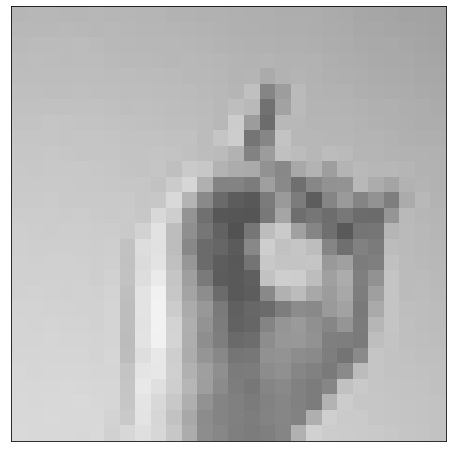

In [43]:
def show_image(ds):
    for images, labels in ds:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        print("Label: " + decode_target(labels.unsqueeze(-1), text_labels = True)[0])
        break
        
show_image(train_ds)

# Moving the Data To Appropriate Processing Unit

In [44]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

In [45]:
device = get_default_device()
device

device(type='cpu')

In [46]:

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# Defining The Model

In [47]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images.long()
        labels = labels.long()
        out = self(images)
        out = out.long()
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images = images.long()
        labels = labels.long()
        out = self(images)
        out = out.long()
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [48]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        xb = xb.long()
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [49]:
model = to_device(ResNet9(1, 26), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Training The Model

In [50]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [51]:
history = [evaluate(model, val_dl)]
history

RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #3 'mat1' in call to _th_addmm_

In [52]:
epochs = 11
max_lr = 0.03
grad_clip = 0.12
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [53]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

NameError: name 'history' is not defined

# Displaying Results

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
plot_accuracies(history)

In [ ]:
evaluate(model, test_dl)

# Saving Results and Hyper-Parameters 

In [ ]:
architecture = ""
lr = []
epochs = []
test_acc = 
test_loss = 

In [ ]:
torch.save(model.state_dict(), 'course-project-final.pth')
jovian.reset()
jovian.log_hyperparams(architecture=architecture, 
                       lr=lr, 
                       epochs=epochs)
jovian.log_metrics(test_loss=test_loss, test_acc=test_acc)
jovian.commit(project=project_name, outputs=['course-project-final.pth'], environment=None)